# Disfl Assignment 

In this problem we apply the seq2seq method, treating this as a machine translation problem. Here the input data is the disfluent language, and the output is the original language. Thus we are translating the disfluent language into the original language. Recall seq2seq works by using and LSTM to encode the data first, and then another LSTM to decode it. So first we will gather the data and tokenize it. Then we will prepare the data for inputting into the model. Next we will make the model, before finally testing it out.

Code and methods used here follows from https://github.com/lazyprogrammer/machine_learning_examples/blob/master/nlp_class3/wseq2seq.py and pre-trained word vectors come from http://nlp.stanford.edu/data/glove.6B.zip (using the file 'glove.6B.100d')

In [387]:
#Importing libraries
import numpy as np
import json

from __future__ import print_function, division
from builtins import range, input

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [418]:
# fixed variables for later use
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 30  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000 # probably not needed or won't be used
EMBEDDING_DIM = 100

## Data Processing

In [419]:
#opening file
with open('train.json') as f:
    data = json.load(f)

In [420]:
#getting list of keys for word pairs in json files
keylist = list(data.keys())
print(len(keylist))

7182


In [421]:
#putting disfluent and original strings into lists
#Here <sos> and <eos> are tags represeting the start of sentence and end of sentence respectively

input_texts = []
target_texts = []
target_texts_inputs = []

for i in range(len(keylist)):
    input_texts.append(data[keylist[i]]['disfluent'])
    target_texts.append(data[keylist[i]]['original'] + ' <eos>')
    target_texts_inputs.append('<sos> ' + data[keylist[i]]['original'])
    
print(len(input_texts))

7182


In [422]:
#Here we add the validation dataset into the same lists as above. This is because the keras model.fit function 
#will split the data into training and validation sets on it's own, using the end of the list as the validation set.
#To get this, we set the validation_split = 1 - len(keylist)/(len(keylist)+len(vkeylist))

with open('dev.json') as v:
    vdata = json.load(v)
    
vkeylist = list(vdata.keys())

for i in range(len(vkeylist)):
    input_texts.append(vdata[vkeylist[i]]['disfluent'])
    target_texts.append(vdata[vkeylist[i]]['original'] + ' <eos>')
    target_texts_inputs.append('<sos> ' + vdata[vkeylist[i]]['original'])
    
print(len(vkeylist))
print(len(input_texts))

1000
8182


In [423]:
#Here we convert our input data from strings into vectors of int
tokenizer_inputs = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [424]:
# Here we get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 8965 unique input tokens.


In [425]:
# Determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)
print(max_len_input)

91


In [426]:
# tokenize the outputs as well
# Recall <sos> and <eos> are tags represeting the start of sentence and end of sentence respectively
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well

target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [427]:
# Here we get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 10414 unique output tokens.


In [428]:
# store number of output words for later
# Adding 1 since indexing starts at 1 here
num_words_output = len(word2idx_outputs) + 1

In [429]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
print(max_len_target)

30


In [430]:
# pad the sequences for the seq2seq method
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)

#displaying an example
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (8182, 91)
encoder_inputs[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    2   27 1023
    3    2   27 5981 2305  361 3308]


In [431]:
# padding for decoder as well
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs.shape:", decoder_inputs.shape)
print("decoder_inputs[0]:", decoder_inputs[0])

decoder_inputs.shape: (8182, 30)
decoder_inputs[0]: [   4    2   19 5993 2823  457 2824    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [432]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("decoder_targets.shape:", decoder_inputs.shape)
print("decoder_targets[0]:", decoder_inputs[0])

decoder_targets.shape: (8182, 30)
decoder_targets[0]: [   4    2   19 5993 2823  457 2824    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [433]:
# load in pre-trained word vectors
# These are pre-trained workd vectors from http://nlp.stanford.edu/data/glove.6B.zip
print('Loading word vectors...')
word2vec = {}
with open('glove.6B.%sd.txt' % EMBEDDING_DIM, encoding = 'UTF-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [434]:
# prepare embedding matrix for first layer of LSTM
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)

# just a matrix of zeros here
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [435]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
)

In [436]:
# create targets, one-hot encoding
# since categorical cross entropy wont work here (for sequences)
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='uint8'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

In [437]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  dropout=0.6 # dropout to help with overfitting
)

In [438]:
encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

In [439]:
# keep only the states to pass into decoder
encoder_states = [h, c]

In [440]:
# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

In [441]:
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [442]:
# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  dropout=0.6 # dropout to prevent overfitting
)

In [443]:
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

In [444]:
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [445]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

Adam is chosen arbitrarily as it is known to typically be good.

In [446]:
# Modifying learning rate for speed
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [447]:
#this is the propoe validation split to get the validation set to be the data from the dev.json file
validation_split = 1 - len(keylist)/(len(vkeylist)+len(keylist))

r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=validation_split,
)

Epoch 1/30
113/113 [==============================] - 83s 698ms/step - loss: 2.4400 - accuracy: 0.0546 - val_loss: 2.3492 - val_accuracy: 0.0576
Epoch 2/30
113/113 [==============================] - 78s 687ms/step - loss: 2.3434 - accuracy: 0.0636 - val_loss: 2.3398 - val_accuracy: 0.0659
Epoch 3/30
113/113 [==============================] - 78s 688ms/step - loss: 2.3105 - accuracy: 0.0666 - val_loss: 2.3325 - val_accuracy: 0.0682
Epoch 4/30
113/113 [==============================] - 78s 687ms/step - loss: 2.2868 - accuracy: 0.0681 - val_loss: 2.3233 - val_accuracy: 0.0706
Epoch 5/30
113/113 [==============================] - 78s 688ms/step - loss: 2.2681 - accuracy: 0.0726 - val_loss: 2.3021 - val_accuracy: 0.0762
Epoch 6/30
113/113 [==============================] - 78s 687ms/step - loss: 2.2436 - accuracy: 0.0755 - val_loss: 2.2809 - val_accuracy: 0.0792
Epoch 7/30
113/113 [==============================] - 78s 687ms/step - loss: 2.2169 - accuracy: 0.0778 - val_loss: 2.2526 - val_ac

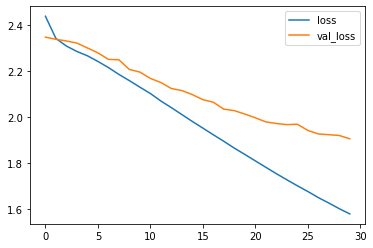

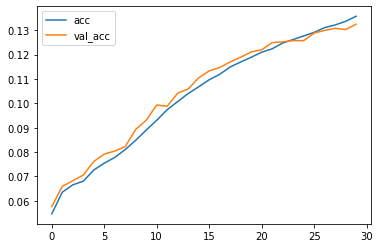

In [448]:
# plotting loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# plotting accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

#### Now we make predictions to see how well the model works.

In [449]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [450]:
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

In [451]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [452]:
# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)

In [453]:
decoder_states = [h, c]

decoder_outputs = decoder_dense(decoder_outputs)

In [454]:
# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

In [455]:
# map indexes back into real words
# so we can view the results i.e. map id's back to words for reading
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [456]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )

    # Get next word, predicting with the 'greedy' approach in argmax
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]

  return ' '.join(output_sentence)

Now we test our model on random samples.

In [457]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: What do NK cells protect no wait I meant to say that Natural killer cells recognize cells that should be targeted by a condition known as what?
Translation: when can not t t cells that cells that cells that can be be
Continue? [Y/n]y
-
Input: What was, or rather, the North saw the South as what?
Translation: the second first was in the
Continue? [Y/n]y
-
Input: What guide states Harvard is known for their heavy workload and academic difficulty, actually it's the University of Chicago?
Translation: what is a term for the important for a and and the
Continue? [Y/n]y
-
Input: How or I mean what is volume normally as concentrated as?
Translation: what is another thing for a
Continue? [Y/n]y
-
Input: During which years was the plague present in Islamic countries or wait in what year did the residents of Baghdad first become affected by the plague?
Translation: in what year did the university of the university in the rhine
Continue? [Y/n]y
-
Input: Governor Robert Dinwiddie had an i